# Federal News Summarization (Base Model Baseline Analysis)

**Research Question:**  
Can an off-the-shelf (no fine-tuning) language model reliably generate structured, policy-relevant summaries of federal agency news that meet production quality requirements or does the complexity of the output format (strict JSON schema, bullet constraints, domain-restricted URLs) require some fine-tuning?

**Why this matters:**  
Before investing in fine-tuning, it's important to know where the base model already performs and where it fundamentally fails. This analysis evaluates the base model across seven structural quality dimensions and one content quality metric (ROUGE-L), establishing the baseline against which future fine-tuned models can be compared.



##1 . Experimental Setup
**Dataset:** 315 federal agency news articles drawn from `.gov` and `.mil` sources.  
**Model:** Base model, no fine-tuning or LoRA adapters applied.  
**Task:** For each article, the model was prompted to return a structured JSON summary containing a `title`, `summary` (formatted as 3–5 bullet points), and `source_url`.

**Evaluation pipeline:**  
Each output was passed through a multi-stage validation pipeline (`run_eval.py`) that checked structural compliance, formatting rules, and content quality. Results were logged to MLflow for reproducibility. The full pipeline is described in the [README](../README.md).

**Production thresholds** (the bar the model must clear to be deployment-ready):

| Metric | Threshold | Rationale |
|---|---|---|
| JSON schema compliance | ≥ 95% | Downstream parsing requires correct structure |
| Bullet formatting | ≥ 95% | Reviewer consistency |
| Bullet count in [3, 5] | ≥ 95% | Core output specification |
| Domain allowlist | 100% | Source reliability is non-negotiable |
| Word count in [70, 250] | ≥ 90% | Minor length deviations tolerable |

**Why ROUGE-L?**

ROUGE-L was selected as the content quality metric over other ROUGE variants and alternatives for three reasons.
1. ROUGE-L uses longest common subsequence (LCS) rather than fixed n-gram overlap (as in ROUGE-1 and ROUGE-2), which makes it better suited to bullet-structured outputs: it rewards summaries that preserve the ordering and flow of key information from the reference, not just the presence of individual words or pairs.
2. ROUGE-L is a standard, interpretable benchmark in the summarization literature, which makes cross-study comparison meaningful even when absolute scores are modest.
3. Semantic similarity metrics like BERTScore (while valuable for capturing paraphrase-level overlap) introduce model-dependent variance that complicates reproducibility across evaluation runs; for a framework designed around cross-run comparison, a deterministic lexical metric is preferable as the primary signal.

ROUGE-L is treated as a diagnostic metric here (no hard threshold) rather than a pass/fail criterion, because its purpose is to track whether fine-tuning improves content alignment with reference summaries, not to gate deployment on its own.

##2. Load Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Baseline results from one evaluation run on the base model (n=315 articles)
metrics = {
    'json_parse_rate': 0.83,
    'json_schema_rate': 0.66,
    'bullet_format_rate': 0.75,
    'bullet_count_in_range_rate': 0.53,
    'summary_wordcount_rate': 0.41,
    'per_bullet_len_rate': 0.66,
    'domain_allowlist_rate': 0.69,
    'rougeLsum_mean': 0.33,
}

latency = {
    'p50_ms': 12900,
    'p95_ms': 15500,
}

# Production thresholds for structual metrics
thresholds = {
    'json_parse_rate': None, # No formal threshold set
    'json_schema_rate': 0.95,
    'bullet_format_rate': 0.95,
    'bullet_count_in_range_rate': 0.95,
    'summary_wordcount_rate': 0.90,
    'per_bullet_len_rate': None, # No formal threshold set
    'domain_allowlist_rate': 1.00,
    'rougeLsum_mean': None, # Diagnostic metric, no hard threshold
}

# Human-readable labels
labels = {
    'json_parse_rate': 'JSON Parse Rate',
    'json_schema_rate': 'JSON Schema Rate',
    'bullet_format_rate': 'Bullet Format Rate',
    'bullet_count_in_range_rate': 'Bullet Count in Range',
    'summary_wordcount_rate': 'Summary Word Count Rate',
    'per_bullet_len_rate': 'Per-Bullet Length Rate',
    'domain_allowlist_rate': 'Domain Allowlist Rate',
    'rougeLsum_mean': 'ROUGE-L Mean',
}
# Create DataFrame with four columns: metric, score, threshold, label
df = pd.DataFrame({
    'metric': list(metrics.keys()),
    'score': list(metrics.values()),
    'threshold': [thresholds[m] for m in metrics.keys()],
    'label': [labels[m] for m in metrics.keys()]
})

# Add columns: has_threshold (valid point?) and passes (score meet threshold?)
df['has_threshold'] = df['threshold'].notna()
df['passes'] = df.apply(lambda r: r['score'] >= r['threshold'] if r['has_threshold'] else None, axis=1)

# Quick summary
print(f"Total metrics evaluated: {len(df)}")
print(f"Metrics with production thresholds: {df['has_threshold'].sum()}")
print(f"Metrics passing threshold: {df['passes'].sum():.0f} / {df['has_threshold'].sum()}")
df

Total metrics evaluated: 8
Metrics with production thresholds: 5
Metrics passing threshold: 0 / 5


,metric,score,threshold,label,has_threshold,passes
0,json_parse_rate,0.83,NaN,JSON Parse Rate,False,None
1,json_schema_rate,0.66,0.95,JSON Schema Rate,True,False
2,bullet_format_rate,0.75,0.95,Bullet Format Rate,True,False
3,bullet_count_in_range_rate,0.53,0.95,Bullet Count in Range,True,False
4,summary_wordcount_rate,0.41,0.90,Summary Word Count Rate,True,False
5,per_bullet_len_rate,0.66,NaN,Per-Bullet Length Rate,False,None
6,domain_allowlist_rate,0.69,1.00,Domain Allowlist Rate,True,False
7,rougeLsum_mean,0.33,NaN,ROUGE-L Mean,False,None


## 3. Pass Rate Overview

The chart below shows each metric's score against its production threshold (where one exists). Bars are colored by pass/fail status: green = meets threshold, red = fails threshold, gray = no threshold defined (diagnostic metric).

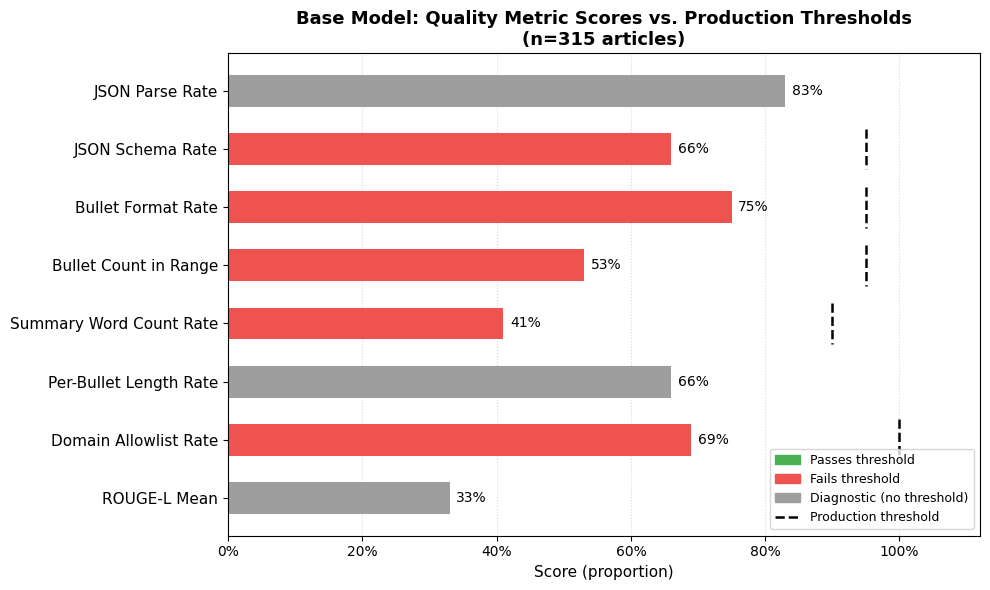

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

# Color logic
colors = []
for _, row in df.iterrows():
  if not row['has_threshold']:
    # gray (diagnostic)
    colors.append('#9e9e9e')
  elif row['passes']:
    # green (passes)
    colors.append('#4caf50')
  else:
    # red (fails)
    colors.append('#ef5350')

y_pos = np.arange(len(df))
bars = ax.barh(y_pos, df['score'], color=colors, height=0.55, zorder=2)

# Draw threshold lines
for i, (_, row) in enumerate(df.iterrows()):
  if row['has_threshold']:
    ax.vlines(row['threshold'], i - 0.35, i +0.35, color='black', linewidth=1.8,
              linestyle='--', zorder=3, label='Threshold' if i == 0 else '')

# Score labels on bars
for bar, (_, row) in zip(bars, df.iterrows()):
  ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
          f"{row['score']:.0%}", va='center', ha='left', fontsize=10)

ax.set_yticks(y_pos)
ax.set_yticklabels(df['label'], fontsize=11)
ax.set_xlim(0, 1.12)
ax.set_xlabel('Score (proportion)', fontsize=11)
ax.set_title('Base Model: Quality Metric Scores vs. Production Thresholds\n(n=315 articles)',
             fontsize=13, fontweight='bold')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.grid(axis='x', linestyle=':', alpha=0.5, zorder=1)
ax.invert_yaxis()

legend_handles = [
    mpatches.Patch(color='#4caf50', label='Passes threshold'),
    mpatches.Patch(color='#ef5350', label='Fails threshold'),
    mpatches.Patch(color='#9e9e9e', label='Diagnostic (no threshold)'),
    plt.Line2D([0], [0], color='black', linewidth=1.8, linestyle='--', label='Production threshold'),
]
ax.legend(handles=legend_handles, loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig('baseline_pass_rates.png', dpi=150, bbox_inches='tight')
plt.show()


**Key observation:** The base model fails every threshold it is evaluated against. No metric reaches its production requirement, and the gap is often large (not marginal).

## 4. Where Does the Model Break Down?

The evaluation pipeline processes each output sequentially: **parse -> validate schema -> check formatting -> check content**. Failures cascade: an output that fails JSON parsing cannot be evaluated on schema, bullets, or ROUGE. Visualizing the metrics in pipeline order reveals where failures originate.

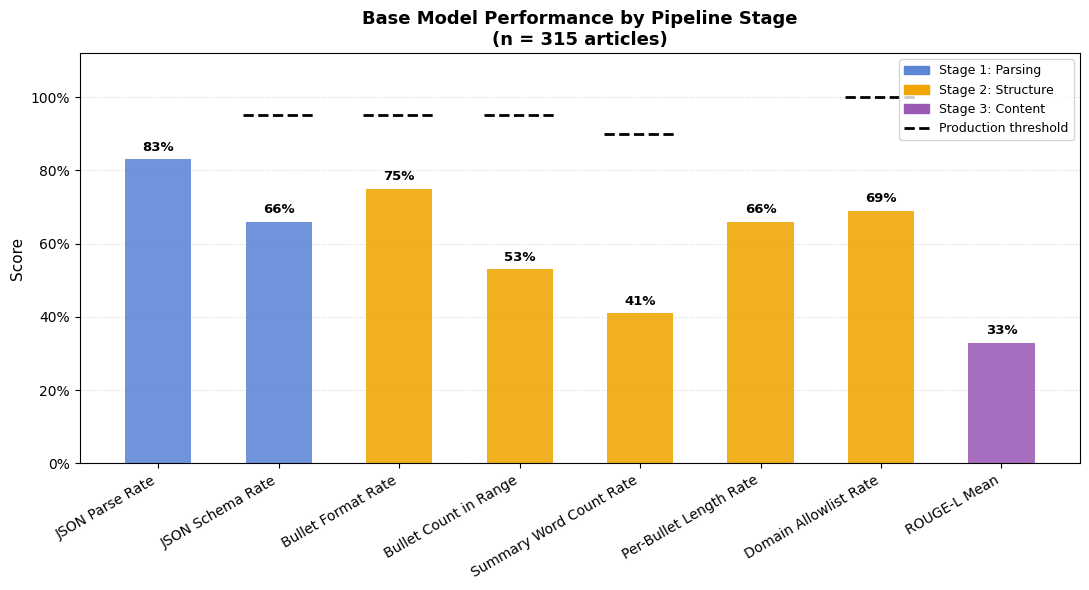

In [7]:
# Ordered by pipeline stage
pipeline_order = [
    ('json_parse_rate', 'JSON Parse Rate', 'Stage 1: Parsing'),
    ('json_schema_rate', 'JSON Schema Rate', 'Stage 1: Parsing'),
    ('bullet_format_rate', 'Bullet Format Rate', 'Stage 2: Structure'),
    ('bullet_count_in_range_rate', 'Bullet Count in Range', 'Stage 2: Structure'),
    ('summary_wordcount_rate', 'Summary Word Count Rate', 'Stage 2: Structure'),
    ('per_bullet_len_rate', 'Per-Bullet Length Rate', 'Stage 2: Structure'),
    ('domain_allowlist_rate', 'Domain Allowlist Rate', 'Stage 2: Structure'),
    ('rougeLsum_mean', 'ROUGE-L Mean', 'Stage 3: Content'),
]

pipeline_df = pd.DataFrame([
    {'key': k, 'label': lbl, 'stage': stage, 'score': metrics[k], 'threshold': thresholds[k]}
    for k, lbl, stage in pipeline_order
])

stage_colors = {
    # Blue for parsing
    'Stage 1: Parsing': '#5c85d6',
    # Yellow for structure
    'Stage 2: Structure': '#f0a500',
    # Purple for content
    'Stage 3: Content': '#9b59b6',
}

fig, ax = plt.subplots(figsize=(11, 6))
x = np.arange(len(pipeline_df))
bar_colors = [stage_colors[s] for s in pipeline_df['stage']]

bars = ax.bar(x, pipeline_df['score'], color=bar_colors, width=0.55, zorder=2, alpha=0.88)

# Threshold markers
for i, (_, row) in enumerate(pipeline_df.iterrows()):
  if pd.notna(row['threshold']):
    ax.hlines(row['threshold'], i - 0.3, i + 0.3, color='black', linewidth=2, linestyle='--', zorder=3)

# Score labels above bars
for bar, (_,row) in zip(bars, pipeline_df.iterrows()):
  ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.015,
          f"{row['score']:.0%}", ha='center', va='bottom', fontsize=9.5, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(pipeline_df['label'], rotation=30, ha='right', fontsize=10)
ax.set_ylabel('Score', fontsize=11)
ax.set_ylim(0, 1.12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f'{v:.0%}'))
ax.set_title('Base Model Performance by Pipeline Stage\n(n = 315 articles)', fontsize=13,
             fontweight='bold')
ax.grid(axis='y', linestyle=':', alpha=0.5, zorder=1)

legend_handles = [
    mpatches.Patch(color=c, label=s) for s, c in stage_colors.items()
] + [plt.Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Production threshold')]
ax.legend(handles=legend_handles, fontsize=9, loc='upper right')

plt.tight_layout()
plt.savefig('baseline_pipeline_stages.png', dpi=150, bbox_inches='tight')
plt.show()

**Key observation:** Failure begins at the parsing stage (only 83% of outputs are valid JSON) and compounds through the pipeline. By the time we reach content constraints (word count, per-bullet length), pass rates have dropped into the low-to-mid 40s. This cascade pattern suggests the primary bottleneck is the model's unreliable adherence to structured output format, not its undertanding of the content.

## 5. Gap Analysis: How Far is the Base Model from Production?

For each metric with a defined threshold, we can quantify the gap by identifying the percentage-point increase needed to reach the production bar. This tells us not just that the model fails, but *how much improvement fine-tuning needs to deliver*.

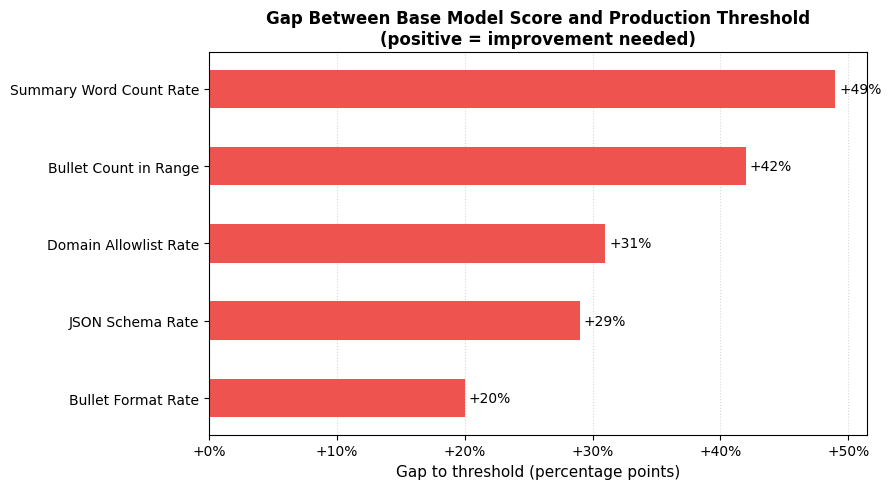


Gap summary:
 Summary Word Count Rate        score=41% threshold=90% gap=+49%
 Bullet Count in Range          score=53% threshold=95% gap=+42%
 Domain Allowlist Rate          score=69% threshold=100% gap=+31%
 JSON Schema Rate               score=66% threshold=95% gap=+29%
 Bullet Format Rate             score=75% threshold=95% gap=+20%


In [9]:
from IPython.core.pylabtools import figsize
gap_df = df[df['has_threshold']].copy()
gap_df['gap'] = gap_df['threshold'] - gap_df['score']
gap_df = gap_df.sort_values('gap', ascending=True)

fig, ax = plt.subplots(figsize=(9, 5))

bar_colors = ['#ef5350' if g > 0 else '#4caf50' for g in gap_df['gap']]
bars = ax.barh(gap_df['label'], gap_df['gap'], color=bar_colors, height=0.5, zorder=2)

ax.axvline(0, color='black', linewidth=1.2, zorder=3)

for bar, (_,row) in zip(bars, gap_df.iterrows()):
  width = bar.get_width()
  offset = 0.003 if width >= 0 else -0.003
  ha = 'left' if width >= 0 else 'right'
  ax.text(width + offset, bar.get_y() + bar.get_height() / 2,
          f"+{width:.0%}" if width > 0 else f"{width:.0%}",
          va='center', ha=ha, fontsize=10)

ax.set_xlabel('Gap to threshold (percentage points)', fontsize=11)
ax.set_title('Gap Between Base Model Score and Production Threshold\n(positive = improvement needed)',
             fontsize=12, fontweight='bold')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f'{v:+.0%}'))
ax.grid(axis='x', linestyle=':', alpha=0.5, zorder=1)

plt.tight_layout()
plt.savefig('baseline_gap_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nGap summary:")
for _, row in gap_df.sort_values('gap', ascending=False).iterrows():
  print(f" {row['label']:<30} score={row['score']:.0%} threshold={row['threshold']:.0%} gap={row['gap']:+.0%}")

**Key observation:** The largest gaps are in word count compliance (-49pp) and bullet count adherence (-42pp). Both of these constraints require the model to calibrate output *length*, not just format. These are the dimensions where fine-tuning on well-structured examples should have the most impact, as the model needs to internalize length norms rather than discover them from the prompt alone.

## 6. Inference Latency

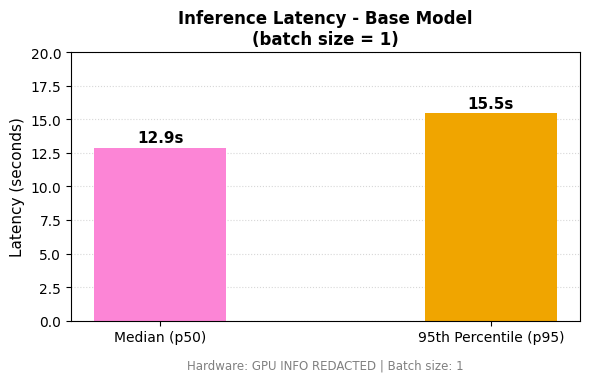

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))

latency_labels = ['Median (p50)', '95th Percentile (p95)']
latency_values = [latency['p50_ms'] / 1000, latency['p95_ms'] / 1000]

bars = ax.bar(latency_labels, latency_values, color=['#fc85d6', '#f0a500'], width=0.4, zorder=2)

for bar, val in zip(bars, latency_values):
  ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.15,
          f'{val:.1f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Latency (seconds)', fontsize=11)
ax.set_ylim(0, 20)
ax.set_title('Inference Latency - Base Model\n(batch size = 1)', fontsize=12, fontweight='bold')
ax.grid(axis='y', linestyle=':', alpha=0.5, zorder=1)

ax.text(0.5, -0.18, 'Hardware: GPU INFO REDACTED | Batch size: 1',
        ha='center', transform=ax.transAxes, fontsize=8.5, color='gray')

plt.tight_layout()
plt.savefig('baseline_latency.png', dpi=150, bbox_inches='tight')
plt.show()

**Key observation:** Median generation latency is 12.9s with a p95 of 15.5s at batch size 1: a  modest tail spread, suggesting consistent generation behavior. Latency benchmarks establish a hardware-normalized reference point; changes in output quality after fine-tuning should be interpreted alongside any changes in latency.

## 7. Summary and Conclusions

### What the baseline tells us

The base model fails to meet every production threshold established for this task. The failure is not marginal (the largest gaps exceed 40 percentage points) and the pattern of failures reveals something structurally meaningful: the model's weakest dimensions are the ones that require calibrated output *length* (word count, bullet count), not just structural awareness.

The cascade structure of failures (**83% JSON parse -> 66% schema -> 41-75% formatting**) confirms that structured output compliance is the primary bottleneck, not content quality. The ROUGE-L score of 0.33, while modest, is consistent with expectations for a base model on a domain-specific summarization task without any task-specific training signal.

### What this means for fine-tuning

These results establish a clear motivation for fine-tuning: the base model knows *what* federal news articles are about, but it does not reliably know *how* to format a structured summary for this specific pipeline. Fine-tuning on a labeled dataset of (article, strucutured summary) pairs, should:

1. Drive JSON parse rate and schema compliance toward the >= 95% threshold by reinforcing the expected output format
2. teach the model to calibrate bullet count (currently 53%) and total word count (currently 41%) through exposure to consistent, well-formed examples
3. Improve ROUGE-L by grounding the model's summarization style in domain-appropriate reference outputs

These baseline metrics will serve as the control condition in all future model comparisons. Any fine-tuned checkpoint will be evaluated using the same pipeline and reported against these values.